# Adsorption and Desorption of CO-Pd with Pyomo

Necessary imports

In [107]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Read in Data

In [108]:
# Area, Extinction Coefficient, Expected Coverage
area_data = scipy.io.loadmat('../DATA/areas.mat')
eps_data = scipy.io.loadmat('../DATA/epsilons.mat')
cov_eq_data = scipy.io.loadmat('../DATA/expected_coverage.mat')

In [109]:
# View headers
print(area_data.keys())
print(eps_data.keys())
print(cov_eq_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'area', 'area_mat', 'time_area'])
dict_keys(['__header__', '__version__', '__globals__', 'epsilon_exp', 'epsilon_sat', 'tp_idx', 'wv_split'])
dict_keys(['__header__', '__version__', '__globals__', 'cov_sat'])


In [110]:
# Areas and time variables
area = np.array(area_data['area'][0])
time = np.array(area_data['time_area'][0])

# Expected coverage at equilibrium
cov_eq = np.array(cov_eq_data['cov_sat'][0])

# Epsilong for low regions and epsilon for saturation regions
eps_low = np.array(eps_data['epsilon_exp'][0])
eps_eq = np.array(eps_data['epsilon_sat'][0])

# Index when pressure is turned off
tp_idx = np.array(eps_data['tp_idx'][0])

Specify constant parameters and labels

In [111]:
# Number of temperature data sets
N = len(area)

# List of labels
temperatures = ['450', '460', '470', '475', '480', '490']

# Constants
P = 0.001  # Pressure of CO in the gas phase

# Measurement resolution
dt = 0.067

# Specify N distinguishing colors for plotting
colors = [
    (1.0, 0.498, 0.0),    # Orange
    (1.0, 0.749, 0.0),    # Light Orange
    (0.7, 0.5, 0),        # Dark Yellow
    (0.6, 0.7, 1.0),      # Light Blue
    (0.4, 0.4, 1.0),      # Medium Blue
    (0.0, 0.0, 1.0)       # Blue
]

# Estimated from prior literature and visual inspection in the latter figure
cut_off = 0.29

# Number of regions
R = 4

Obtain the coverage deterministically through the area for each temperature based on the weighting assumption of the extinction coefficient. In contrast, in our proposed approach we model this relationship probabilistically.

In [112]:
# Get coverage from area deterministically
cov = []
for n in range(N):
    A = area[n]
    w = A/max(A)
    eps_val = w*eps_eq[n] + (1-w)*eps_low[n]
    cov.append( (A/eps_val)[0])

Visualize Coverage Data - Note that because it is obtained deterministically through the area with noise, some values are below $0$.

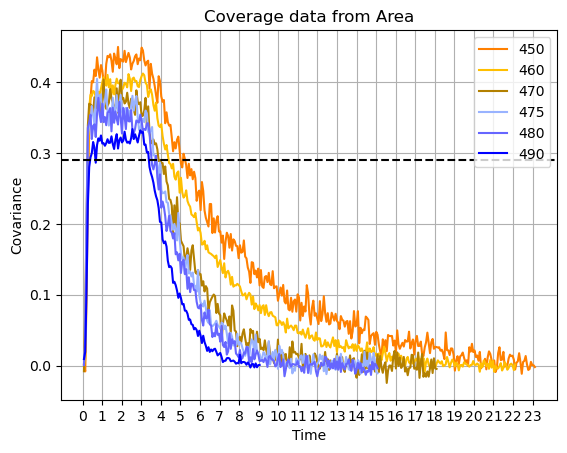

In [113]:
# Create a new figure
plt.figure()

# Plot coverage for all temperatures in one figure
for n in range(N):
    plt.plot(time[n], cov[n], color = colors[n])  # Plot the n-th pair with a label

plt.axhline(y=cut_off, color='black', linestyle='--')

# Formatting
plt.xlabel('Time') 
plt.ylabel('Covariance')  
plt.title('Coverage data from Area') 
plt.legend(temperatures)  
plt.grid(True)
plt.xticks(range(0, int(max(time[0])) + 1))

# Show the plot
plt.show()

### Pyomo Dynamic Optimization implementation

In [114]:
# We estimate the R3 to R4 split with the following time stamps for each temperature 
idx_split = []
time_cut_off = []
for n in range(N):
    indices = [i for i,c in enumerate(cov[n][tp_idx[0]:]) if c > cut_off]
    idx_split.append(indices[-1]+tp_idx[0])
    time_cut_off.append(float(time[n][idx_split[-1]]))
    
# Number of points in R1
idx_R1 = 6

In [115]:
# Function for the solver - will be applied to R14 and R23 separately
def apply_pyomo_solver(timejoint, covjoint, idx_R1, dt, P, time1, cov1, time2, cov2):

    cov_joint = []

    # Create the model
    model = ConcreteModel()

    # Define a discrete set for time points
    model.t = Set(initialize = timejoint)

    # Define the coverage variable, indexed by the discrete set
    model.coverage = Var(model.t, bounds=(0, 0.5))

    # Parameters to optimize: k1 and k2
    model.k1 = Var(bounds=(0, None), initialize=0.1)  # Desorption rate constant
    model.k2 = Var(bounds=(0, None), initialize=0.05)  # Adsorption rate constant

    # Define the Proposed Models
    def coverage_difference_rule(m, t):
        # Time jumps
        previous_time = t - dt 
        if previous_time in m.t:
            if previous_time > dt*idx_R1:
                return m.coverage[t] == m.coverage[previous_time] -(m.k1 * m.coverage[previous_time]) * (t - previous_time)
            else:
                return m.coverage[t] == m.coverage[previous_time] + (m.k2 * P * (0.5 - m.coverage[previous_time]) - m.k1 * m.coverage[previous_time]) * (t - previous_time)
        else:
            # because our first time data point starts with dt not 0
            return Constraint.Skip
    model.coverage_eq = Constraint(model.t, rule=coverage_difference_rule)

    # Initial and boundary condition
    model.coverage[time1[0]].fix(max(cov1[0],0))
    model.coverage[time1[-1]].fix(cov1[-1])
    model.coverage[time2[0]].fix(cov2[0])
    model.coverage[time2[-1]].fix(max(cov2[-1],0))
    

    # Define least squares loss function
    def fit_coverage_rule(m):
        # (Fitted - Data)^2
        return sum((m.coverage[t] - covjoint[i])**2 for i, t in enumerate(m.t))  
    
    # Fit the model to the observed data
    model.obj = Objective(rule=fit_coverage_rule, sense=minimize)

    # Solve the model
    solver = SolverFactory('ipopt')
    solver.solve(model, tee=False)

    # Store the fitted results of the new region
    cov_joint = [model.coverage[t]() for t in model.t]

    # Store the estimated rate constants per region
    k_des = model.k1.value
    k_ads = model.k2.value

    return [k_ads, k_des, cov_joint, timejoint]

### REGIONS 1 and 4

In [116]:
# Region 1 and 4

# For fitted coverage
covR1 = []
covR4 = []

timeR1 = []
timeR4 = []

k_ads_R14 = []
k_des_R14 = []

# Joint 
cov_R14 = []
time_R14 = []


# Get data
for n in range(N):

    #  Extract and Concatenate data for R1 and R4
    timeR1.append([i*dt for i in range(0,idx_R1)])
    timeR4.append([i*dt for i in range(idx_split[n],len(time[n]))])

    # Separate R1 and R4 coverage data
    covR1.append(list(cov[n][:idx_R1]))
    covR4.append(list(cov[n][idx_split[n]:len(cov[n])+1]))

    # Concatenated coverage data R1 and R4
    covR14 = list(covR1[n]) + list(covR4[n])
    timeR14 = timeR1[n] + timeR4[n]

    # Apply Solver
    k_ads14, k_des14, cov14, time14 = apply_pyomo_solver(timeR14, covR14, idx_R1, dt, P, timeR1[n], covR1[n], timeR4[n], covR4[n])

    # Store rate constants for each temp
    k_ads_R14.append(k_ads14)
    k_des_R14.append(k_des14)

    # Store fitted cov and time for plotting
    cov_R14.append(cov14)
    time_R14.append(time14)




### REGIONS 2 and 3

In [117]:
# Region 2 and 3

# For fitted coverage
timeR2 = []
timeR3 = []

covR2 = []
covR3 = []

# Joint
time_R23 = []
cov_R23 = []

k_ads_R23 = []
k_des_R23 = []

# Get data
for n in range(N):

    #  Extract and Concatenate data for R2 and R3
    timeR2.append([i*dt for i in range(idx_R1,tp_idx[0])])
    timeR3.append([i*dt for i in range(tp_idx[0], idx_split[n])])

    # Separate R1 and R4 coverage data
    covR2.append(list(cov[n][idx_R1:tp_idx[0]]))
    covR3.append(list(cov[n][tp_idx[0] : idx_split[n]]))

    # Concatenated coverage data R2 and R3
    covR23 = covR2[n] + covR3[n]
    timeR23 = timeR2[n] + timeR3[n]

    # Apply Solver
    k_ads23, k_des23, cov23, time23 = apply_pyomo_solver(timeR23, covR23, idx_R1, dt, P, timeR2[n], covR2[n], timeR3[n], covR3[n])

    # Store rate constants
    k_ads_R23.append(k_ads23)
    k_des_R23.append(k_des23)

    # Store coverage and time for plotting
    cov_R23.append(cov23)
    time_R23.append(timeR23)
    


### Reorganize for easy plotting

In [118]:
time_plot = []
cov_plot = []
for n in range(N):
    time_plot.append(timeR1[n] + time_R23[n] + timeR4[n])
    cov_plot.append(covR1[n] + cov_R23[n] + covR4[n])

#### Visualize Results

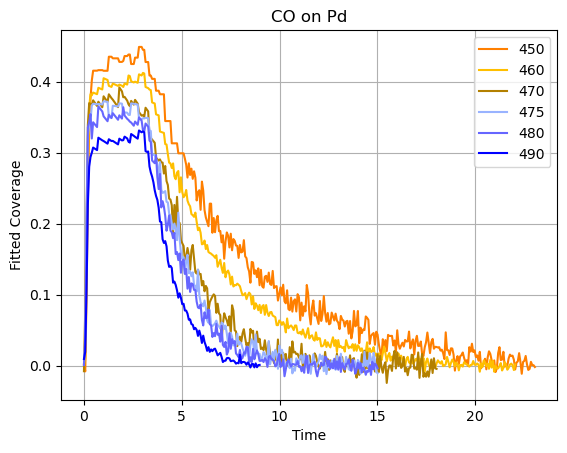

In [119]:
# Fitted coverages for all temperatures
plt.figure()

for n in range(N):
    plt.plot(time_plot[n], cov_plot[n], color = colors[n])

# Labels
plt.xlabel('Time')
plt.ylabel('Fitted Coverage')
plt.title('CO on Pd')
plt.grid(True)
plt.legend(temperatures)
plt.show()

#### Plot fitting against data

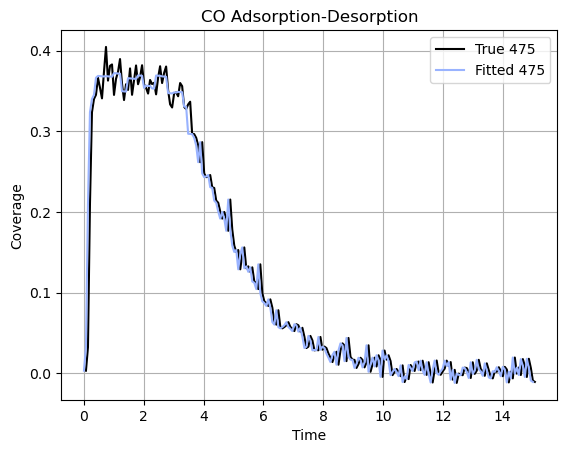

In [120]:
''' Choose temperature index
n = 0 --> 450 K
n = 1 --> 460 K
n = 2 --> 470 K
n = 3 --> 475 K
n = 4 --> 480 K
n = 5 --> 490 K
'''
n = 3

# Create figure
plt.figure()
plt.plot(time[n],cov[n], color = (0,0,0) )
plt.plot(time_plot[n], cov_plot[n], color = colors[n])

# Labels
plt.xlabel('Time')
plt.ylabel('Coverage')
plt.title('CO Adsorption-Desorption')
plt.grid(True)
plt.legend(['True ' +  temperatures[n] , 'Fitted ' + temperatures[n]])
plt.show()

In [121]:
print(f'Adsorption rate constant in R{1}: k_ads = {k_ads_R14}')
print(f'Adsorption rate constant in R{2}: k_ads = {k_ads_R23}')
print(f'Desorption rate constant in R{3}: k_des = {k_des_R23}')
print(f'Desorption rate constant in R{4}: k_des = {k_des_R14}')

Adsorption rate constant in R1: k_ads = [3649.0078913937477, 3878.405421225781, 3848.133869605043, 3576.727536301222, 3703.053239138899, 2573.4803366925166]
Adsorption rate constant in R2: k_ads = [2096.044314755891, 588.9039514831129, 1049.9553624352302, 290.1010721619518, 2068.1831294786357, 625.5121815449884]
Desorption rate constant in R3: k_des = [3.5198603071418146e-07, 0.03011766711758798, 0.10574200561098325, 0.009726484942819896, 0.09847523639804252, 0.05796771682942979]
Desorption rate constant in R4: k_des = [0.023093808419430654, 0.13660894379421948, 0.3933050934339516, 0.6126159872049425, 0.5507332295021262, 0.387272297352303]


In [122]:
k = [k_ads_R14, k_ads_R23, k_des_R23, k_des_R14]

In [123]:
table = [[f'{k[r][n]}' for r in range(4)] for n in range(6)]

# Print the table to see the result
for n in range(N):
    print(temperatures[n], 'K: Adsorption k_ads =  ', table[n][:2], '    Desorption k_des = ', table[n][2:])


450 K: Adsorption k_ads =   ['3649.0078913937477', '2096.044314755891']     Desorption k_des =  ['3.5198603071418146e-07', '0.023093808419430654']
460 K: Adsorption k_ads =   ['3878.405421225781', '588.9039514831129']     Desorption k_des =  ['0.03011766711758798', '0.13660894379421948']
470 K: Adsorption k_ads =   ['3848.133869605043', '1049.9553624352302']     Desorption k_des =  ['0.10574200561098325', '0.3933050934339516']
475 K: Adsorption k_ads =   ['3576.727536301222', '290.1010721619518']     Desorption k_des =  ['0.009726484942819896', '0.6126159872049425']
480 K: Adsorption k_ads =   ['3703.053239138899', '2068.1831294786357']     Desorption k_des =  ['0.09847523639804252', '0.5507332295021262']
490 K: Adsorption k_ads =   ['2573.4803366925166', '625.5121815449884']     Desorption k_des =  ['0.05796771682942979', '0.387272297352303']


## Activation Energy and Pre-exponential Factors

### Linearized

In [124]:
import numpy as np
from scipy.stats import linregress

def calculate_Ea_and_lnA(temperatures, rate_constants, R_constant):

    # Convert temperatures to 1/T
    inverse_temperatures = 1 / np.array(temperatures)
    x = inverse_temperatures/R_constant
    
    # Take the natural log of the rate constants
    ln_k = np.log(rate_constants)

    # Perform linear regression on ln(k) vs 1/T
    slope, intercept, r_value, p_value, std_err = linregress(inverse_temperatures, ln_k)

    std_err_intercept = std_err * np.sqrt(1/N + np.mean(x)**2 / np.sum((x - np.mean(x))**2))

    # Calculate activation energy from the slope (-Ea/R)
    Ea = -slope * R_constant
    lnA = intercept


    return [Ea, lnA, std_err*R_constant, std_err_intercept*R_constant]


In [125]:
temperatures_vals = np.array([450., 460., 470., 475., 480., 490.])
R_constant = 0.001987204258  # Gas constant in kcal/(mol·K)
labels = ['Adsorption R1', 'Adsorption R2', 'Desorption R23','Desorption R14']


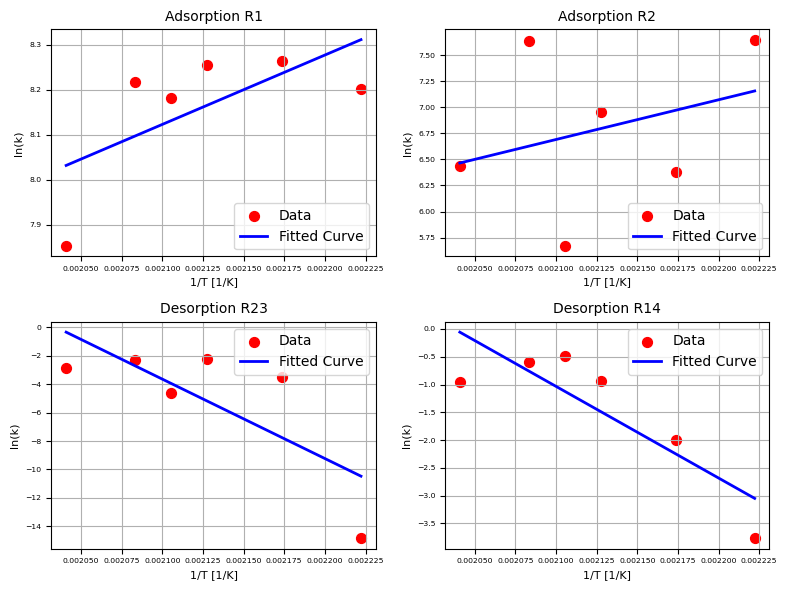

In [126]:
Ea = []
lnA = []
se = []

# Create subplots: 2 rows, 2 columns (since R=4)
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()   

# For
for r in range(R):
    rate_constants = np.array(k[r], dtype=float)  # example rate constants

    Ea_region, lnA_region, stdEa, stdlnA = calculate_Ea_and_lnA(temperatures_vals, rate_constants, R_constant)

    Ea.append(Ea_region)
    lnA.append(lnA_region)
    se.append([stdEa, stdlnA])

    # Optional: plot the results
    T_fit = np.linspace(min(temperatures_vals), max(temperatures_vals), 100)
    lnk_fit = - Ea_region/(T_fit*R_constant) + lnA_region


    # Plot in corresponding subplot
    ax = axes[r]
    ax.scatter(1/temperatures_vals, np.log(rate_constants), color='red', label='Data', s=50)  # Data points
    ax.plot(1/T_fit, lnk_fit, color='blue', linewidth=2, label='Fitted Curve')  # Fitted curve
    ax.set_xlabel('1/T [1/K]', fontsize=8)
    ax.set_ylabel('ln(k)', fontsize=8)
    ax.set_title(labels[r], fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=5.5)
    ax.legend()
    ax.grid()

plt.subplots_adjust(hspace=0.1, wspace=0.55)  # Increase vertical (hspace) and horizontal (wspace) space
plt.tight_layout()


In [127]:
for r in range(R):
    print(f'R{r+1}: Activation Energy Ea =  ',Ea[r],'+/- ', se[r][0], ' and Pre-exponential factor lnA = ', lnA[r],'+/- ', se[r][1])

R1: Activation Energy Ea =   -3.0597815076939505 +/-  1.805242120106444  and Pre-exponential factor lnA =  4.889369560367017 +/-  26.44946097624084
R2: Activation Energy Ea =   -7.567629907359842 +/-  11.28716683085226  and Pre-exponential factor lnA =  -1.30678347509701 +/-  165.37365004941492
R3: Activation Energy Ea =   111.13886248202677 +/-  49.882875993274034  and Pre-exponential factor lnA =  113.80733272305486 +/-  730.857743275438
R4: Activation Energy Ea =   32.75294836330569 +/-  9.951818010321677  and Pre-exponential factor lnA =  33.5783749243206 +/-  145.80881931290938


### Nonlinear regression

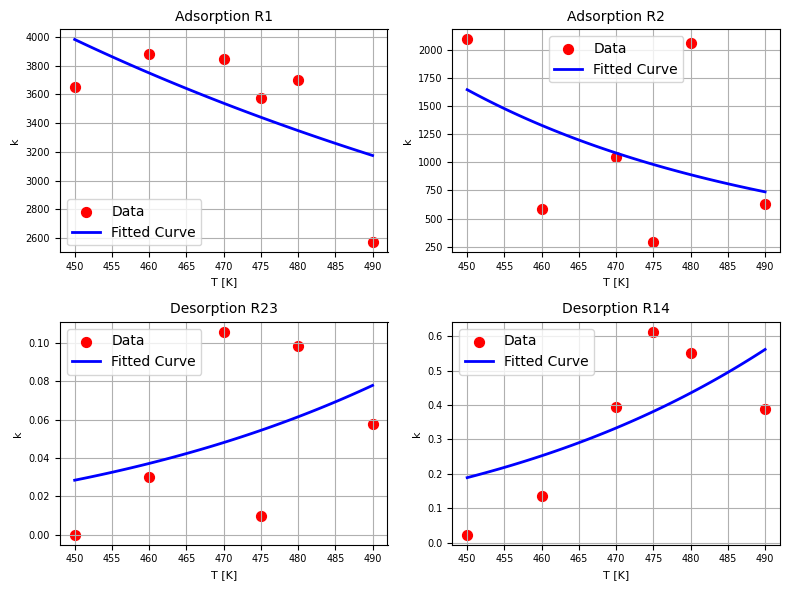

In [131]:
from scipy.optimize import curve_fit


# Arrhenius function to fit
def arrhenius_eq(T, A, Ea):
    return A * np.exp(-Ea / (R_constant * T))

Ea_init = [Ea[0],Ea[1],10,Ea[3]]
A_init = [exp(lnA[0]), exp(lnA[1]), 1e10, exp(lnA[3])]

Ea_nl = []
A_nl = []
se_nl = []

# Create subplots: 2 rows, 2 columns (since R=4)
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()  

for r in range(R):

    # Initial guess for [A, Ea]
    initial_guess = [A_init[r], Ea_init[r]]  # Example initial guess for A and Ea

    rate_constants = np.array(k[r], dtype=float)

    # Perform nonlinear regression
    params, covariance = curve_fit(arrhenius_eq, temperatures_vals, rate_constants, p0=initial_guess)

    # Extract fitted parameters
    A_fit, Ea_fit = params

    Ea_nl.append(Ea_fit)
    A_nl.append(A_fit)

    # Calculate standard errors
    std_errors = np.sqrt(np.diag(covariance))

    se_nl.append(std_errors)

    # Optional: plot the results
    T_fit = np.linspace(min(temperatures_vals), max(temperatures_vals), 100)
    k_fit = arrhenius_eq(T_fit, *params)


     # Plot in corresponding subplot
    ax = axes[r]
    ax.scatter(temperatures_vals, rate_constants, color='red', label='Data', s=50)  # Data points
    ax.plot(T_fit, k_fit, color='blue', linewidth=2, label='Fitted Curve')  # Fitted curve
    ax.set_xlabel('T [K]', fontsize=8)
    ax.set_ylabel('k', fontsize=8)
    ax.set_title(labels[r], fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.legend()
    ax.grid()

plt.subplots_adjust(hspace=0.1, wspace=0.55)  # Increase vertical (hspace) and horizontal (wspace) space
plt.tight_layout()


In [132]:
for r in range(R):
    print(f'R{r+1}: Activation Energy Ea = ',Ea_nl[r],'+/-', se_nl[r][1], ' and Pre-exponential factor A =', A_nl[r],'+/-', se_nl[r][0])

R1: Activation Energy Ea =  -2.4794157629957785 +/- 1.6263066655473997  and Pre-exponential factor A = 248.84551920240708 +/- 434.8331830559152
R2: Activation Energy Ea =  -8.806268463555096 +/- 9.74789711962166  and Pre-exponential factor A = 0.08715302637331195 +/- 0.9240470852779208
R3: Activation Energy Ea =  11.057445018625392 +/- 13.58145175822316  and Pre-exponential factor A = 6654.6905220151075 +/- 95017.66083901154
R4: Activation Energy Ea =  11.948066865633047 +/- 8.294327659661793  and Pre-exponential factor A = 119824.65910313222 +/- 1044266.2171356415
